<a href="https://colab.research.google.com/github/Hero0963/data_science_camp_level3/blob/main/task01/ptt_crawler_visualization_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PTT Crawler



In [58]:
!pip install requests requests_html rich lxml PyQuery
!pip install beautifulsoup4

In [59]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.ptt.cc/bbs/index.html'

# 發送 HTTP GET 請求並獲取網頁內容
response = requests.get(url)
content = response.text

# 使用 BeautifulSoup 解析 HTML 內容
soup = BeautifulSoup(content, 'html.parser')

# 找到所有熱門看板的元素
hotboard_elements = soup.find_all('div', class_='b-ent')


board_name_list = []
# 獲取前10大即時熱門看板名稱
for i, element in enumerate(hotboard_elements[:10]):
    board_name = element.find(class_='board-name').text
    board_name_list.append(board_name)


print(board_name_list)

['Gossiping', 'C_Chat', 'Stock', 'NBA', 'Baseball', 'HatePolitics', 'Lifeismoney', 'LoL', 'KoreaStar', 'home-sale']


In [60]:
import urllib.parse
import re

def parse_next_link(controls):
    link = controls[1].attrs['href']
    next_page_url = urllib.parse.urljoin('https://www.ptt.cc/', link)
    return next_page_url


# 解析該頁文章列表中的元素
def parse_article_entries(elements):
    results = []
    for element in elements:
        try:
            push = element.find('.nrec', first=True).text  # 推文數
            mark = element.find('.mark', first=True).text  # 標記
            title = element.find('.title', first=True).text # 標題
            author = element.find('.meta > .author', first=True).text # 作者
            date = element.find('.meta > .date', first=True).text # 發文日期
            link = element.find('.title > a', first=True).attrs['href'] # 文章網址
        except AttributeError:
            # 處理文章被刪除的情況
            if '(本文已被刪除)' in title:
                match_author = re.search('\[(\w*)\]', title)
                if match_author:
                    author = match_author.group(1)
            elif re.search('已被\w*刪除', title):
                match_author = re.search('\<(\w*)\>', title)
                if match_author:
                    author = match_author.group(1)
        # 將解析結果加到回傳的列表中
        if (push.isdigit() and int(push) > 70):
            results.append({'push': int(push), 'mark': mark, 'title': title,
                        'author': author, 'date': date, 'link': link})
        elif ("爆" in push):
            results.append({'push': 100, 'mark': mark, 'title': title,
                        'author': author, 'date': date, 'link': link})
    return results


In [61]:
from requests_html import HTMLSession


session = HTMLSession()

In [62]:
import collections

# 存解析的結果
record = collections.defaultdict(list)
base_url = 'https://www.ptt.cc/bbs/{}/index.html'
# 想要收集的頁數
num_page = 10

for board_name in board_name_list:
    if board_name == 'Gossiping':
        session.cookies.set('over18', '1')  # 向網站回答滿 18 歲了 !

    # 構建完整的網址
    url = base_url.format(board_name)
    results = []
    for page in range(num_page):
        response = session.get(url)
        # 解析文章列表的元素
        result = parse_article_entries(elements=response.html.find('div.r-ent'))
        if result:
            results.append(result)
        # 解析下一個連結
        next_page_url = parse_next_link(controls=response.html.find('.action-bar a.btn.wide'))
        url = next_page_url


    record[board_name] = results
    # 範例：輸出看板名稱及網址
    # print(f'看板名稱：{board_name}')
    # print("results = ", results)
    # print('---')

In [63]:
# for board_name, results in record.items():
#     print(board_name)
#     for result in results:
#         print(result)

In [64]:
import pandas as pd


with pd.ExcelWriter('output.xlsx') as writer:
    for board_name, results in record.items():
        data = []
        for result in results:
            for r in result:
                push = r['push']
                mark = r['mark']
                title = r['title']
                author = r['author']
                # 其他欄位...

                data.append({'push': push, 'mark': mark, 'title': title, 'author': author})
                # 添加其他欄位

        df = pd.DataFrame(data)
        print("board_name = ", board_name)
        display(df)
        df.to_excel(writer, sheet_name=board_name, index=False)

board_name =  Gossiping


,push,mark,title,author
0,100,,[協尋] 6/28晚 重新路3段 行車記錄器（按推P幣）,guana
1,100,,[協尋] 父親桃園失蹤,zero95154
2,99,,[新聞] 快訊／范瑋琪挺陳建州被罵爆 演唱會取,ihcc
3,98,,[新聞] 總統民調／政壇me too風暴後 柯文哲領先賴清德居第一,emuless
4,75,,[新聞] 踢爆TPASS廣告不加「行政院」就沒補助,FiveSix911
5,100,,[新聞] 獨／拖TPASS補助款 悠遊卡董座：10日未,hk410050
6,99,,[問卦] 高戰爭風險國正副元首全家人躲美國?!,davis0918


board_name =  C_Chat


,push,mark,title,author
0,100,M,[公告] 第一屆西洽最婆大會 ＆ 置底推文閒聊區,Satoman
1,100,M,[公告] 七月看板活動 希洽動畫推薦大賞,Satoman
2,100,,[討論] [Vtub] Hololive 晚間直播單 (1120707),timsun105
3,100,,[推投] 2023「春番」最喜歡電視動畫「3票」,MrSatan
4,97,,[蔚藍] 老師你回來了啊...!,kerycheng


board_name =  Stock


,push,mark,title,author
0,100,,[閒聊] 2023/07/07 盤後閒聊,vendan5566
1,100,,[情報] 112年07月07日 三大法人買賣金額統計表,coconing
2,78,,[新聞] 中國晶圓教父籲兩岸合作突破美限制 工,suntw
3,100,M,[閒聊] 2023/07/07 盤中閒聊,justforsing
4,100,,[請益] 大盤破線還有人多單沒停損的嗎,jinso7410
5,78,,[請益] 這次跌到萬二484就能歐印了,cmelo1515
6,100,,[新聞] 台股今重挫近300點 金管會再信心喊話：基,Player01
7,91,,Re: [請益] 不小心違約交割了,fishyesunno
8,85,,[情報] 0706 上市外資買賣超排行,saber50116
9,100,,[新聞] 台灣6月CPI年漲1.75%逾2年新低 漲幅收斂,ntpcgov


board_name =  NBA


,push,mark,title,author
0,77,,[新聞] 美國隊公布世界盃陣容 年輕世代接棒老,s66449
1,100,,[新聞] 網友灌爆法國怪物IG要求道歉 布蘭妮:他還,kobest
2,100,,[花邊] 熱火的報價未達去年D.Murray交易的水準,Kazmier
3,100,M,[情報] 2023-24 自由市場 總整理 (7/7),laigei
4,100,,[情報] 小李希望阿拓與熱火進行有意義的談判,Skyblueway
...,...,...,...,...
63,99,,[情報] 小李可能會以不幫其他球隊打球強行去熱火,stevenchiang
64,83,,[討論] Tyler Herro現在適合哪一隊？,Ayanami5566
65,89,,Re: [新聞] 交易要求遭球迷批評 Lillard疑惑不解,Subaru5566
66,92,,[情報] Anthony Edwards和灰狼續約,willy911006


board_name =  Baseball


,push,mark,title,author
0,81,,[新聞] 台鋼雄鷹首輪選不選林子偉？ 領隊：有,iamshana
1,76,,[情報] 樂天FB -辣酷甜趴,gogoto990
2,72,,[新聞] 「愛你喔！」兄弟簽下新洋投艾里歐 預計,sukiya
3,96,,[新聞] SPC-藝人威廉與胡智爲、唐肇廷是好友,kman5566
4,71,,[新聞] WZH-MLB／大谷翔平偏愛西海岸球團！巨人,Skyblueway
5,100,,[討論] 引起討論的安田尚憲再見安打,choobii
6,71,,[新聞] 等一個正職缺 合庫台電0參與選秀,thnlkj0665
7,94,,[討論] 統一=中職公務員，富邦=？,LMG5566
8,100,,[討論] 中職一軍跟韓職一軍平均實力算是差不多嗎,Xinpeicity
9,99,,[分享] 今日王柏融,bengowa


board_name =  HatePolitics


,push,mark,title,author
0,100,,[新聞] 遭爆養豬場超貸 陳冠廷直播公開資料邀黃,win8719
1,79,,[討論] 所以為何柯打不死,Sinreigensou
2,97,,[轉錄] 黃國昌FB:雜糧基金會董事長林源泉今天辭職,keel90135


board_name =  Lifeismoney


,push,mark,title,author
0,81,,[情報] 中華電信生活節 我的幸運神射手,weq2018
1,92,M,[公告] 板務分工&違規檢舉區,medama
2,100,M,[公告] 贈送集中文,medama
3,100,,Fw: [情報] 7-11 國民便當7/11上市,fim
4,76,,[新聞] 穿「比基尼」吃王品「套餐1折」！5大鍋,rich22084
5,87,,[情報] uniqlo airism內褲 190,MisuzuXD
6,94,,[情報] 全家 7/5～7/9 限時優惠,jou705
7,100,M,[公告] 寶島眼鏡廣告文水桶,medama
8,73,M,Re: [公告] 寶島眼鏡廣告文水桶,medama
9,100,,[情報] yahoo購物中心 購物金80元,pooet


board_name =  LoL


,push,mark,title,author
0,100,M,[公告] 伺服器狀況詢問/聊天/揪團/抱怨/多功能區,samhou6
1,100,M,[電競] 2023 LPL Summer W6D5,cornsoup
2,96,,[閒聊] FOFO韓服ID改成我有罪,kemao
3,100,,[情報] 杭州亞運《英雄聯盟》台灣正選名單出爐,YahooEsports
4,100,,[電競] 亞洲電子競技公開賽 咆嘯深淵總決賽,rainnawind
5,79,,Re: [新聞] Toyz還是倒了…鍾培生狠命揍臉 TKO取勝：說我輸的人在,pitbull0123
6,76,,[閒聊] DFM tol2 稱自己遭受教練恐嚇面臨生命威脅,y12544
7,71,,[情報] 妮可分身直昇機延長視野,lydia520327
8,84,,[戰棋] 這狗屎版本還要玩多久,tavern
9,100,,[閒聊] TPA戰歌是不是很high,david0426


board_name =  KoreaStar


,push,mark,title,author
0,100,,[閒聊] NewJeans先行Intro - New Jeans MV,usenwo
1,100,,[閒聊] 提到有著漂亮鼻子的偶像，你會想到誰？,XOD
2,80,,[閒聊] 2023上半年日本KPOP女偶像搜尋排名,Fantasy7th
3,100,,[新聞] 粉絲玩笑問借錢！舒華回「燒給你」惹議,saintmin1002
4,100,,[情報] INFINITE 演唱會 臺北場09.02,Im22Yo
5,100,,"[閒聊] NewJeans 新歌""Super Shy"" MV",Master5566
6,100,,[閒聊] NMIXX新曲 韓網反應:完全放棄MIXX POP曲,Teentop
7,100,,[閒聊] FIFTY FIFTY在Cultwo Show中對代表的反應,Master5566
8,92,,[閒聊] 一組海外藝人團體，韓語說得比你想像的好,XOD
9,71,,[閒聊] 如果你是Fifty Fifty 你會怎麼做？,abiann


board_name =  home-sale


,push,mark,title,author
0,100,M,[公告] 置底檢舉區,angel07
1,75,,[閒聊] 買法拍屋會很丟臉嗎？,JQK2
2,92,,Re: [心得] 七八年級生 這輩子別想等房價下跌了,ceca


In [65]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [79]:
import os
os.listdir('/content')

['.config',
 'TaipeiSansTCBeta-Regular.ttf',
 'output.xlsx',
 '.ipynb_checkpoints',
 'sample_data']

In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 設定字體路徑
font_path = '/content/TaipeiSansTCBeta-Regular.ttf'

# 設定字體
mpl.rcParams['font.family'] = mpl.font_manager.FontProperties(fname=font_path).get_name()

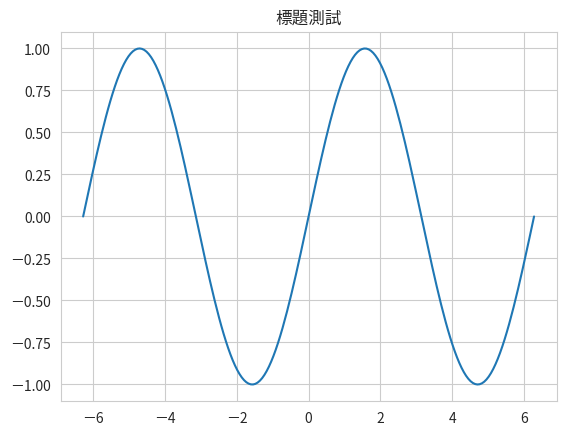

In [84]:
import numpy as np

x = np.linspace(-2*np.pi, 2* np.pi, 200)
y = np.sin(x)

plt.title('標題測試')
plt.plot(x,y)

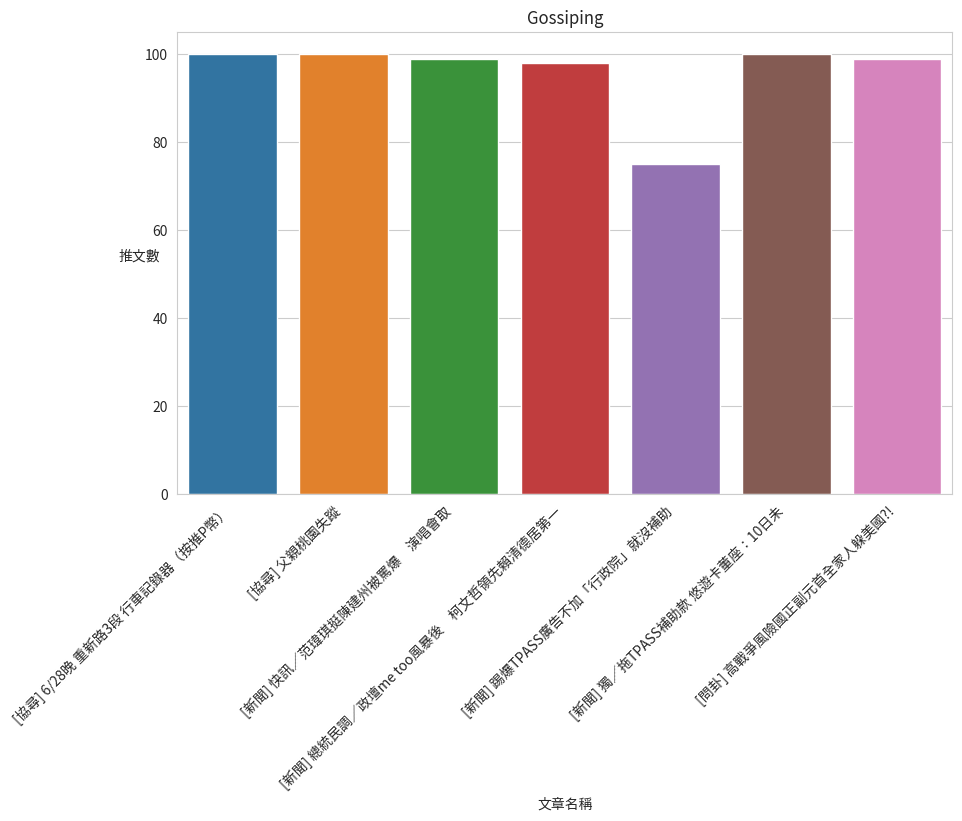

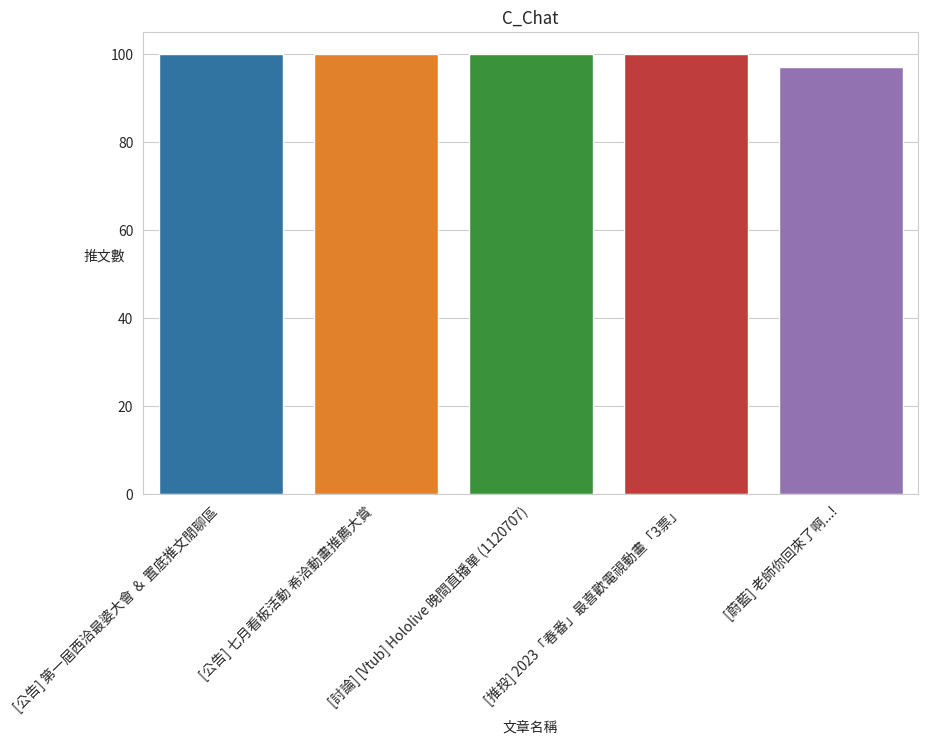

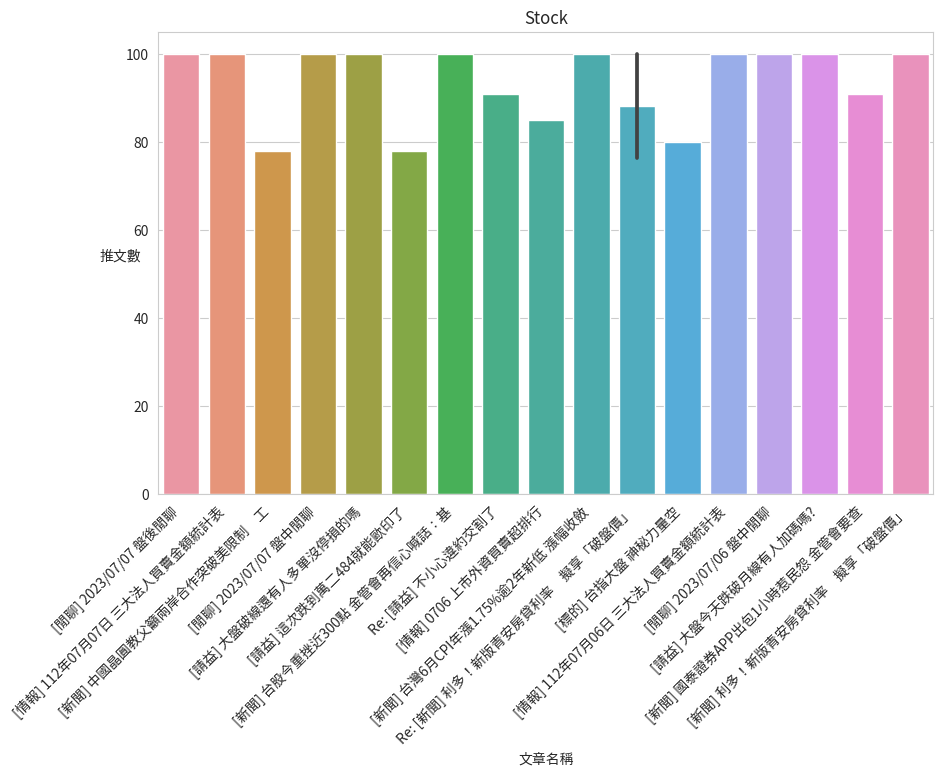

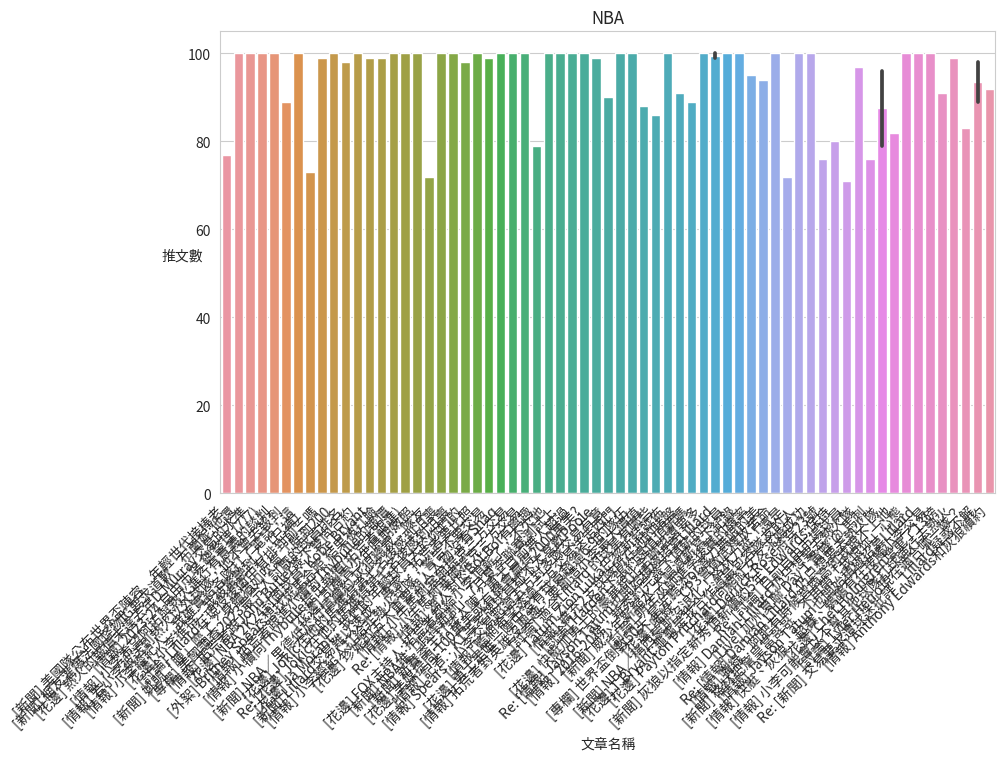

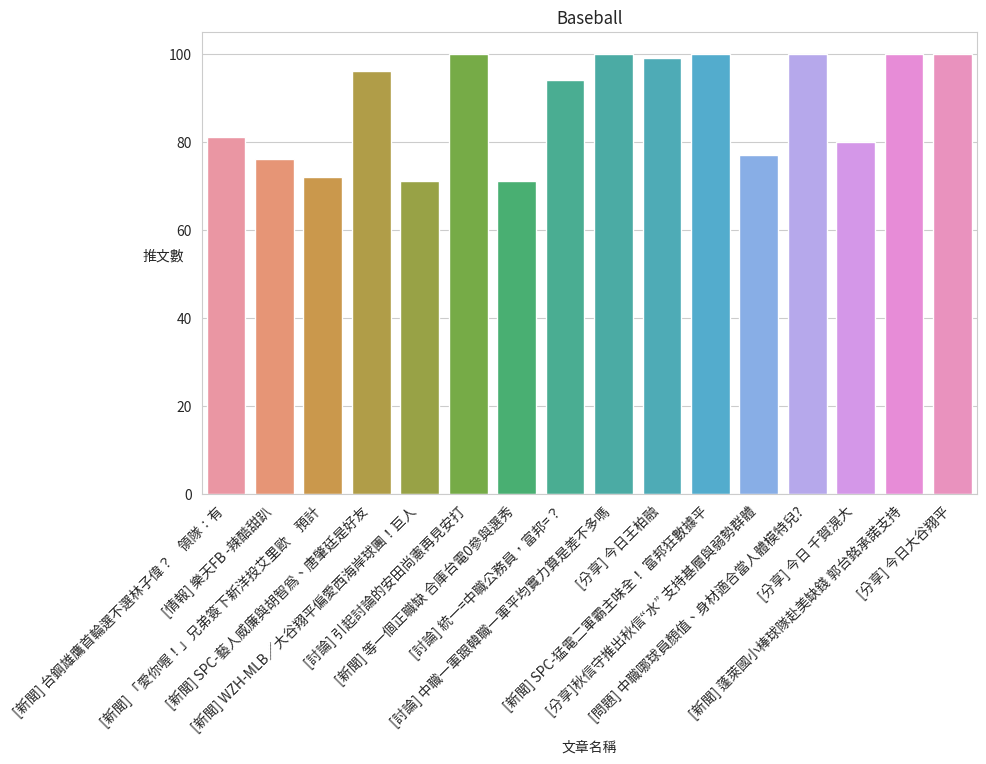

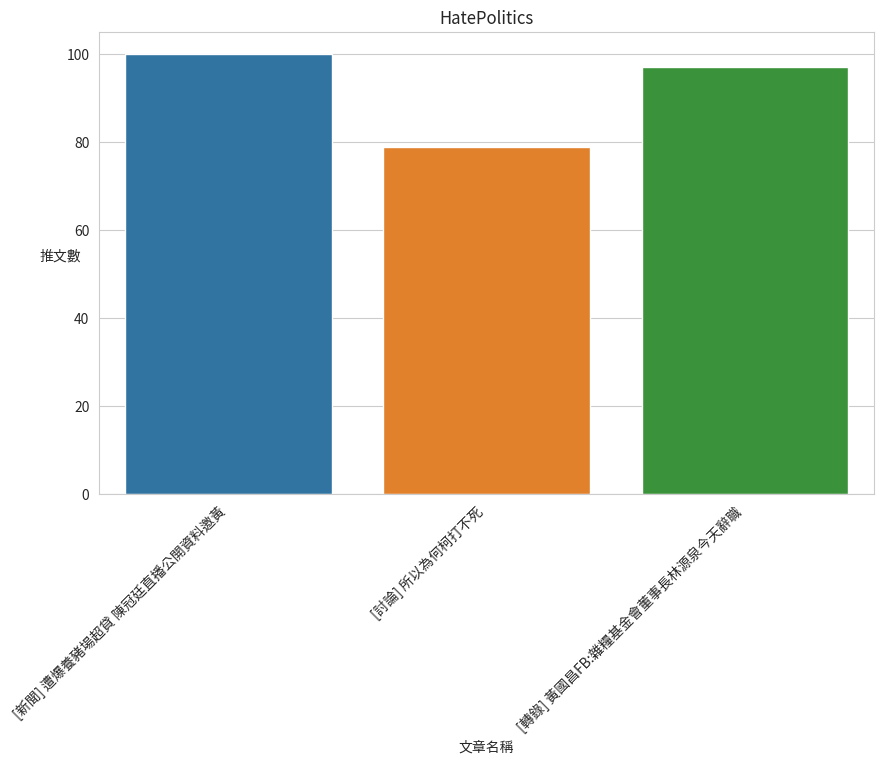

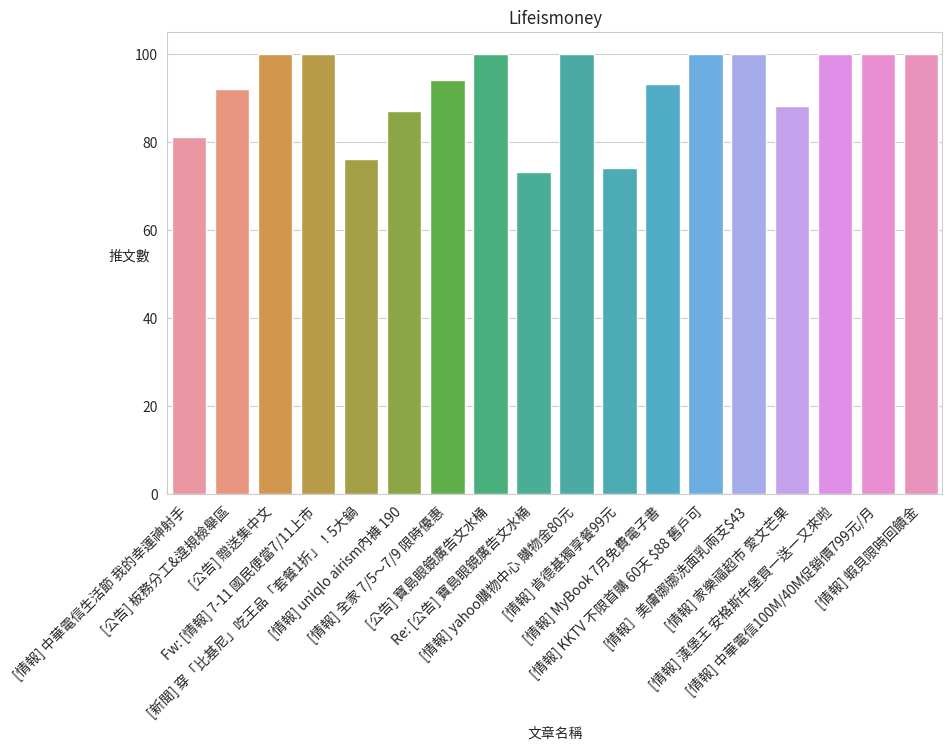

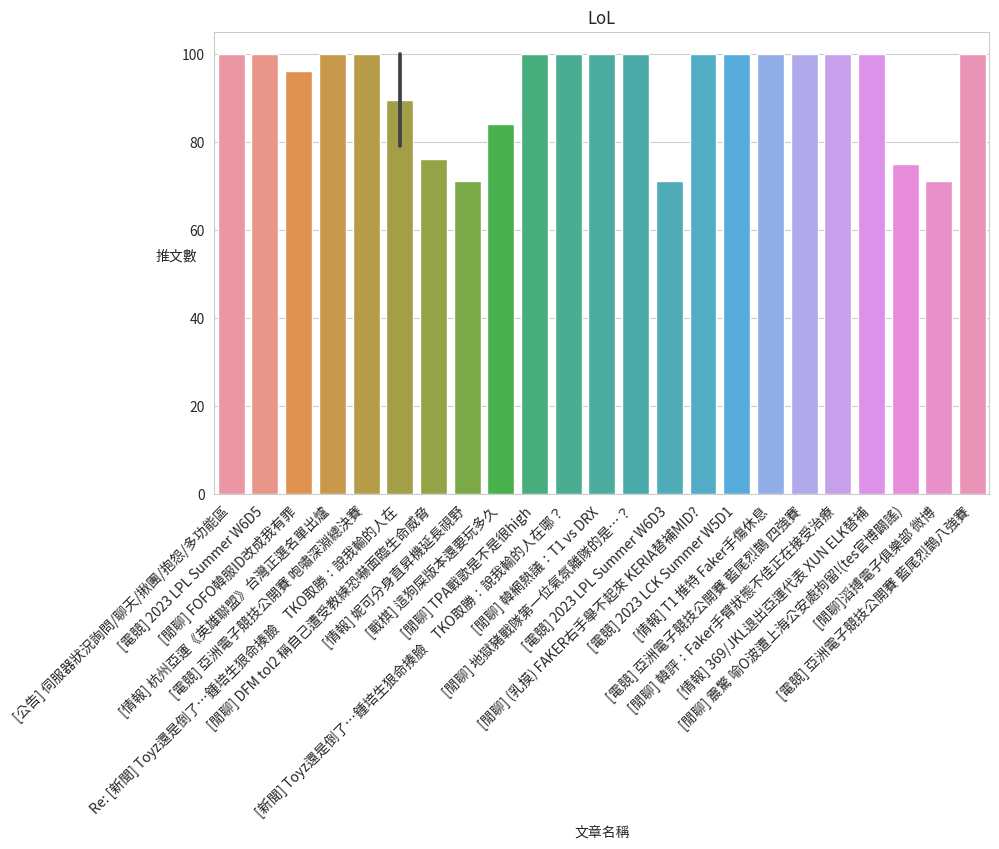

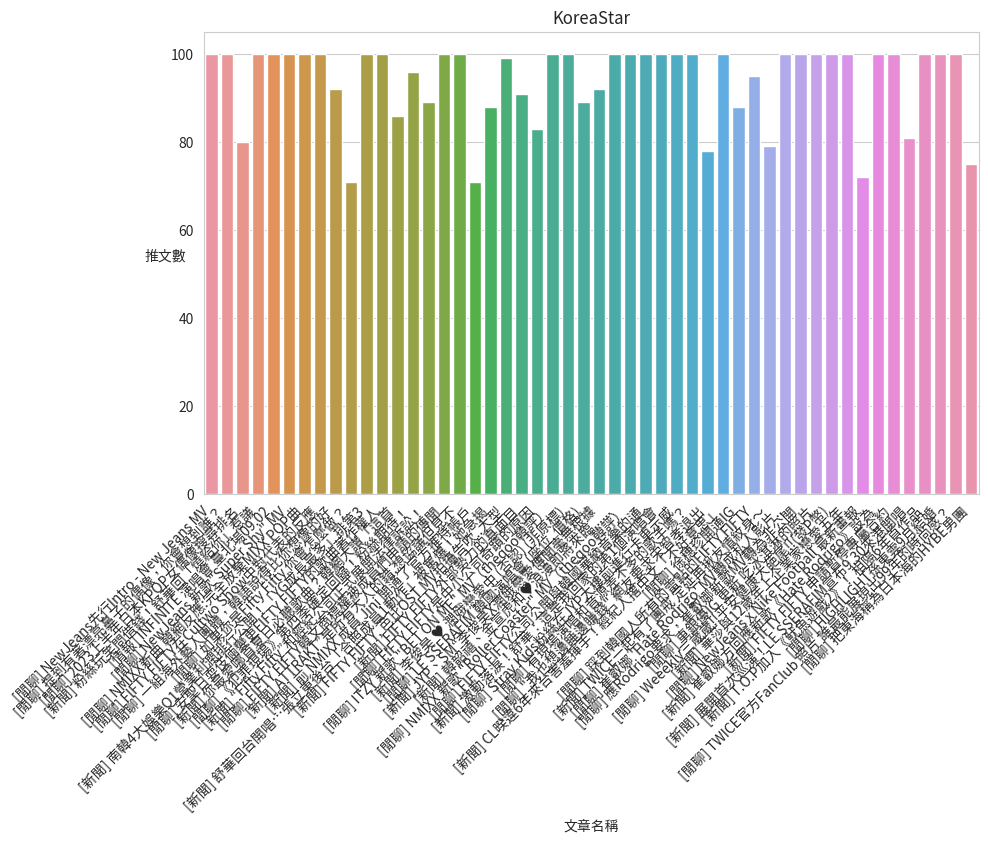

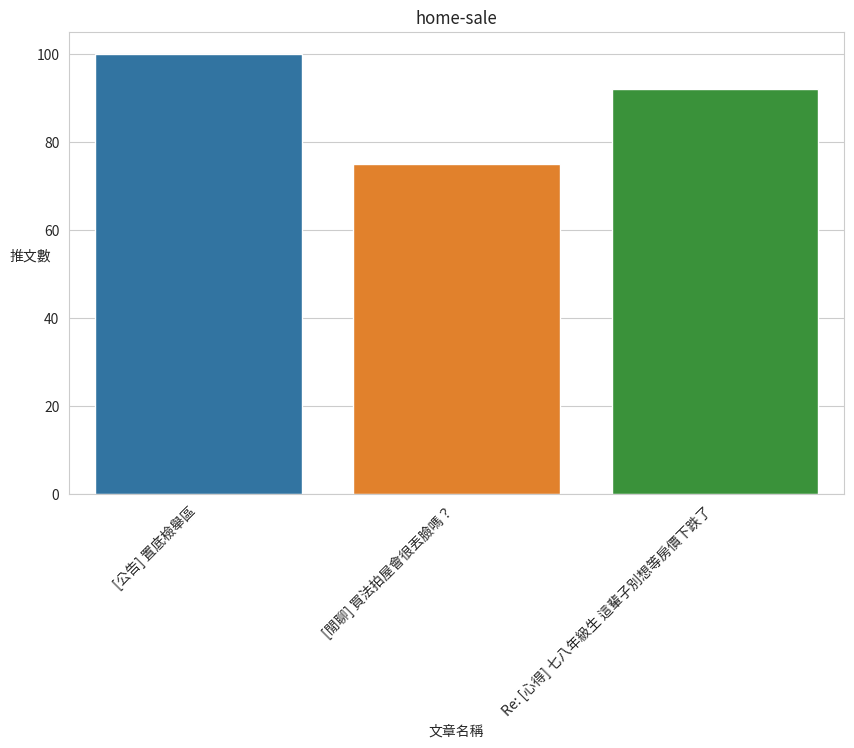

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



for board_name, results in record.items():
    data = []
    for result in results:
        for r in result:
            push = r['push']
            mark = r['mark']
            title = r['title']
            author = r['author']
            # 其他欄位...

            data.append({'push': push, 'mark': mark, 'title': title, 'author': author})
            # 添加其他欄位

    df = pd.DataFrame(data)
    pushes = df['push']
    titles = df['title']

    # 設置圖表的大小和樣式
    plt.figure(figsize=(10, 6))


    # 使用 Seaborn 繪製長條圖
    sns.barplot(x=titles, y=pushes)

    # 設置標籤和標題
    plt.xlabel('文章名稱')
    plt.ylabel('推文數', rotation='horizontal')
    plt.title(board_name)

    # 自動調整 x 軸標籤以避免重疊
    plt.xticks(rotation=45, ha='right')
    plt.xticks(fontsize=10)

    # 顯示圖表
    plt.show()



# 參考資料:  
- [GitHub - CrawlerTutorial](https://github.com/leVirve/CrawlerTutorial) + chatgpt  
- [如何在 Colab 中顯示繁體中文](https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb#scrollTo=RfR0uymWF3cB)